#### Обучение без учителя. Алгоритмы кластеризации

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from collections import defaultdict
import random

Реализация оригинального алгоритма кластеризации, в основе которого лежит нахождение площади треугольника между тремя ближайшими друг к другу точками.

Задается максимально допустимая площадь треугольника, превышая которую, алгоритм задает новый кластер. Производится N итераций (по размеру исходного массива)

**Ограничение**: данный алгоритм разработан для работы с двумерными входными данными, имеет недочеты

In [56]:
class TriangleAreaKMeans:
    def __init__(self, max_area):
        """Инициализация параметров кластеризации
        Args:
        max_area: максимальная допустимая площадь треугольника (порог). 
                  По умолчанию 0.2                   
        """
        self.max_area = max_area if max_area else 0.2
        self.scaler = MinMaxScaler()
        self.labels_ = None
        self.centers_ = None
        self.data = None

    @staticmethod
    def calculate_triangle_area(a, b, c):
        """Вычисление площади треугольника по трём точкам.
        Args:
        a, b, c: координаты точек"""
        return 0.5 * np.abs(a[0]*(b[1] - c[1]) + b[0]*(c[1] - a[1]) + c[0]*(a[1] - b[1]))

    @staticmethod
    def check_cos(a,b,c):
        """Вычисление по косинусу, лежат ли точки на одной прямой.
        Args:
        a, b, c: координаты точек"""
        for i in [(a,b,c), (c,b,a)]:
            try:
                acos = (i[0]**2 + i[1]**2 - i[2]**2) / (2 * i[0] * i[1])
                if acos == 1:
                    return True
            except:
                continue
        return False
            
    def check_convert_data(self, X):
        """Проверка и преобразование входных данных в numpy.ndarray.
        Args:
        X: датафрейм или массив данных"""
        if isinstance(X, pd.DataFrame):
            if len(X.select_dtypes(include=[np.number]).columns) == 0:
                raise ValueError("В датафрейме нет числовых колонок")
            X = X.to_numpy()
        if X.ndim != 2:
            raise ValueError("Входные данные не являются двумерными")
        return X

    def normalize_data(self, X):
        """Нормализация(масштабирование) данных"""
        return self.scaler.fit_transform(X)

    def fit(self, X, normalize=None):
        """Обучение модели на данных X.
        Args:
        X: датафрейм или массив данных
        normalize: метка для масштабирования данных (по умолчанию False)"""
        X = self.check_convert_data(X)
        # Нормализуем (масштабируем) данные, если normalize = True
        normalize = normalize if normalize else False
        if normalize:
            X = self.normalize_data(X)
            self.data = X
            self.max_area /= 1000 
            
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        current_cluster = 1
        for i in range(n_samples):
            # Находим два ближайших соседа для точки i
            distances = distance.cdist(X[i:i+1], X, metric='euclidean')
            nearest_indices = np.argsort(distances[0])[1:3]  # первые два ближайших соседа (исключая саму точку)
            
            # Вычисляем площадь треугольника
            a, b, c = X[i], X[nearest_indices[0]], X[nearest_indices[1]]
            area = self.calculate_triangle_area(a, b, c)

            d_ab = distance.euclidean(a, b)
            d_ac = distance.euclidean(a, c)
            d_bc = distance.euclidean(b, c)
            # Если площадь больше порога, самая удалённая точка из трёх должна быть в другом кластере
            if area > self.max_area or self.check_cos(d_ab, d_ac, d_bc):
                # Находим самую удалённую точку из трёх
                max_distance = max(d_ab, d_ac, d_bc)

                if max_distance == d_bc and abs(sum(c)) > abs(sum(b)):
                    remote_point = nearest_indices[1]
                elif max_distance == d_ac and abs(sum(a)) > abs(sum(c)):
                    remote_point = i
                else:
                    remote_point = nearest_indices[0]

                self.labels_[i] = current_cluster
                current_cluster += 1

        # Пересчитываем принадлежность точек к кластерам
        for i in range(n_samples):
            if self.labels_[i] == 0:
                # Если точка ещё не в кластере, присваиваем ей ближайший кластер
                cluster_distances = []
                for cluster in np.unique(self.labels_):
                    if cluster == 0:
                        continue
                    cluster_points = X[self.labels_ == cluster]
                    if len(cluster_points) == 0:
                        continue
                    cluster_center = np.mean(cluster_points, axis=0)
                    dist = distance.euclidean(X[i], cluster_center)
                    cluster_distances.append((cluster, dist))
                if cluster_distances:
                    nearest_cluster = min(cluster_distances, key=lambda x: x[1])[0]
                    self.labels_[i] = nearest_cluster

        self.centers_ = np.array([X[self.labels_ == cluster].mean(axis=0)
                                          for cluster in np.unique(self.labels_) if cluster != 0])
    
    def fit_transform(self, X, normalize=None):
        """
        Обучение модели и возврат матрицы расстояний от каждой точки до центров кластеров.
        Args:
        X: датафрейм или массив данных
        normalize: метка для масштабирования данных (по умолчанию False)"""
        self.fit(X, normalize=normalize)
        # Вычисляем расстояния от каждой точки до каждого центра кластера
        distances = distance.cdist(X, self.centers_, metric='euclidean')
        return distances

    def fit_predict(self, X, normalize=None):
        """Обучение модели и возврат метки кластеров.
        Args:
        X: датафрейм или массив данных
        normalize: метка для масштабирования данных (по умолчанию False)"""
        self.fit(X, normalize=normalize)
        return self.labels_, self.centers_

In [57]:
def draw_plot(X, centers, c=True):
    """Рисование и отображение графика.
    Args:
    X: датафрейм или массив данных
    centers: центры кластеров"""
    if isinstance(X, pd.DataFrame):
        plt.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='tab10', s=40)
    else:
        plt.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=40)
    if c:
        plt.scatter(centers[:,0], centers[:,1], c='red', marker='X', s=40)
    plt.title("Результат кластеризации")
    plt.show()

#### Применение алгоритма кластеризации на массивах

In [58]:
A = np.array([[1, 1], [0, 0], [2, 0], [4, 4], [5, 5], [5, 3]])

model = TriangleAreaKMeans(max_area=0.99)
labels, centers = model.fit_predict(A, normalize=False)
print("Метки кластеров:", labels)

Метки кластеров: [1 2 3 4 5 6]


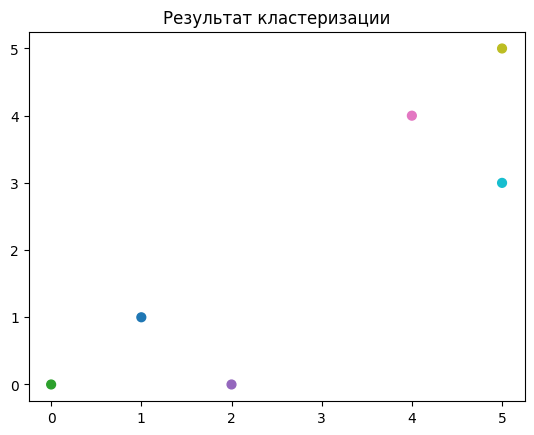

In [59]:
draw_plot(A, centers, c=False)

In [60]:
X, y_true = make_blobs(n_samples=400,
                       centers=3,
                       cluster_std=[0.8, 1.2, 0.7],
                       random_state=42)

In [61]:
model = TriangleAreaKMeans(max_area=0.22)
labels, centers = model.fit_predict(X, normalize=False)

print("Метки кластеров:", labels)

Метки кластеров: [2 1 2 4 1 1 1 2 1 4 2 1 2 1 2 3 3 1 3 2 1 2 1 1 1 2 2 1 3 2 2 4 2 2 1 3 1
 4 1 4 1 2 2 2 3 3 1 3 1 3 1 2 3 4 4 2 1 1 2 3 3 3 2 4 1 1 2 3 4 2 1 2 2 1
 2 1 2 3 1 1 3 1 2 2 3 4 2 3 1 2 3 1 2 4 1 2 2 3 3 1 4 1 1 2 2 4 4 3 3 1 1
 2 3 1 2 2 2 3 2 1 3 1 2 1 2 3 3 3 2 1 1 1 3 2 3 2 1 2 1 2 1 3 2 4 1 2 3 1
 2 1 2 1 2 1 2 1 3 1 1 1 1 1 3 2 1 2 3 2 2 2 2 1 3 3 3 1 1 1 4 2 4 1 3 3 2
 3 1 1 2 3 1 2 2 3 2 3 2 2 2 2 3 1 2 1 1 4 2 1 2 3 1 3 1 1 4 3 2 1 1 1 2 1
 1 3 3 1 3 1 4 1 3 1 3 2 2 3 2 2 3 3 1 1 2 1 4 4 1 1 3 3 4 4 1 2 3 2 1 3 2
 2 1 3 4 2 2 4 2 2 1 4 1 3 2 1 1 2 1 1 3 2 1 1 2 2 1 1 2 2 2 4 3 2 1 1 4 2
 1 1 1 2 2 3 2 4 3 2 4 2 2 1 1 1 2 4 1 1 3 1 3 3 3 4 2 2 1 4 2 1 3 1 1 3 1
 3 2 3 2 1 1 2 2 2 3 1 2 4 4 2 2 1 3 3 2 4 2 3 3 1 3 1 2 2 3 3 2 2 4 4 4 2
 1 2 2 2 1 2 3 2 3 3 1 3 3 2 2 1 1 4 4 2 1 2 1 1 2 3 3 2 1 1]


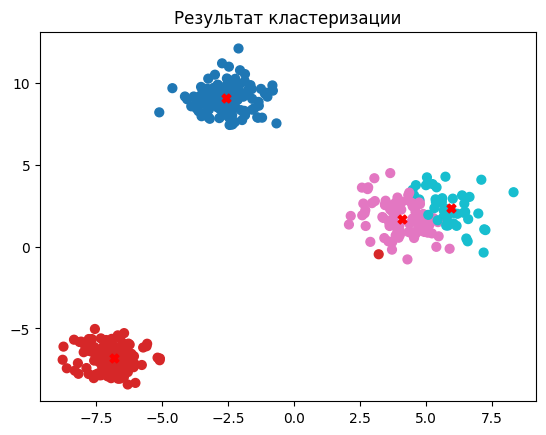

In [62]:
draw_plot(X, centers)

#### Применение алгоритма кластеризации на датафреймах

In [63]:
iris = load_iris()
X = iris.data
y = iris.target
df = pd.DataFrame(X, columns=iris.feature_names)
df = df[["sepal length (cm)","petal length (cm)"]]
df

,sepal length (cm),petal length (cm)
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3
3,4.6,1.5
4,5.0,1.4
...,...,...
145,6.7,5.2
146,6.3,5.0
147,6.5,5.2
148,6.2,5.4


In [64]:
model = TriangleAreaKMeans(max_area=0.62)
labels, centers = model.fit_predict(df, normalize=True)

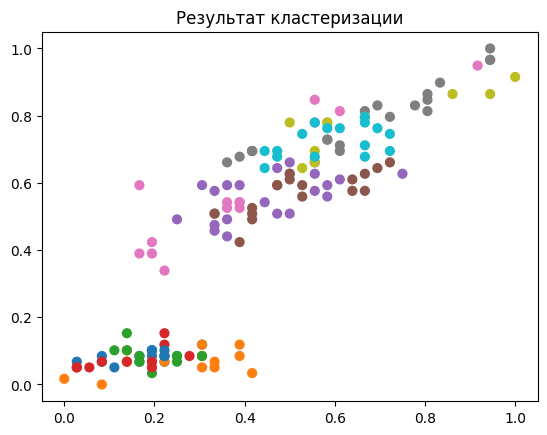

In [65]:
df_norm = model.normalize_data(df)
draw_plot(df_norm, centers, c=False)

In [66]:
df2 = pd.read_csv("data/mall_customers_clustering.csv")
df2 = df2[["Income", "Score"]]

In [67]:
model = TriangleAreaKMeans(max_area=0.3)
labels, centers = model.fit_predict(df2, normalize=True)

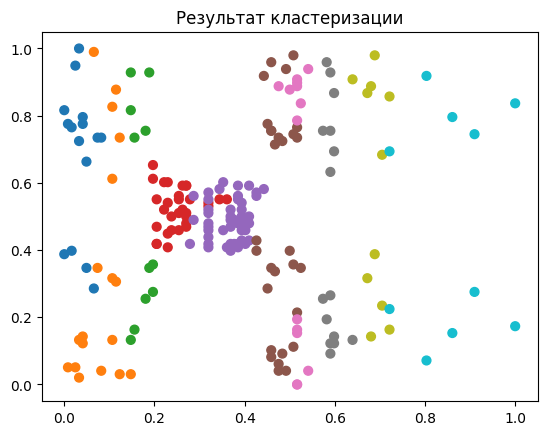

In [68]:
df2_norm = model.normalize_data(df2)
draw_plot(df2_norm, centers, c=False)

Реализуем также традиционный и один из наиболее распространенных алгоритмов: алгоритм К-средних, с учетом условий:
- критерий останова (max_iters - максимальное кол-во итераций и n_replace - максимальное кол-во объектов, которые поменяли кластер)
- возможность масштабировать  датасет до обучения модели
- возможность подавать на вход dataframe с numerical колонками

In [73]:
class KMeans2:
    def __init__(self, clusters, max_iters=None, random_state=None, n_replace=None):
        """Инициализация параметров кластеризации
        Args:
        clusters: количество кластеров
        max_iters: максимальное количество итераций. По умолчанию 100
        random_state: параметр для установки начального состояния генератора 
                      случайных чисел. По умолчанию 42
        n_replace: максимальное количество объектов, поменявших кластер. По умолчанию 1
        """
        self.clusters = clusters
        self.random_state = random_state if random_state else 42
        self.max_iters = max_iters if max_iters else 100
        self.n_replace = n_replace if n_replace else 1
        self.scaler = MinMaxScaler()
        self.labels_ = None
        self.centers_ = None
        self.data = None
        
    def check_convert_data(self, X):
        """Проверка и преобразование входных данных в numpy.ndarray.
        Args:
        X: датафрейм или массив данных"""
        if isinstance(X, pd.DataFrame):
            if len(X.select_dtypes(include=[np.number]).columns) == 0:
                raise ValueError("В датафрейме нет числовых колонок")
            X = X.select_dtypes(include=[np.number]).to_numpy()
        return X

    def normalize_data(self, X):
        """Нормализация(масштабирование) данных"""
        return self.scaler.fit_transform(X)
        
    def fit(self, X, normalize=None):
        """Обучение модели на данных X.
        Args:
        X: датафрейм или массив данных
        normalize: метка для масштабирования данных (по умолчанию False)"""
        X = self.check_convert_data(X)
        if normalize:
            X = self.normalize_data(X)
            self.data = X
            
        np.random.seed(self.random_state)
        # Выбираем случайные точки из данных
        indices = np.random.choice(X.shape[0], self.clusters, replace=False)
        self.centers_ = X[indices]
        current_labels = None
        
        for _ in range(self.max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centers_, axis=2)
            labels = np.argmin(distances, axis=1)
            if current_labels is not None:
                # Проверка критерия останова: не более `n_replace` объектов поменяли кластер
                if np.sum(labels != current_labels) <= self.n_replace:
                    break
            current_labels = labels.copy()
            new_centers = []
            for k in range(self.clusters):
                cluster_points = X[labels == k]
                if len(cluster_points) > 0:
                    new_centers.append(cluster_points.mean(axis=0))
                else:
                    # Если кластер пустой, оставляем старый центроид
                    new_centers.append(self.centers_[k])
            
            self.centers_ = np.array(new_centers)
        # Сохраняем финальные метки
        self.labels_ = current_labels       
                
    def fit_transform(self, X, normalize=None):
        """
        Обучение модели и возврат матрицы расстояний от каждой точки до центров кластеров.
        Args:
        X: датафрейм или массив данных
        normalize: метка для масштабирования данных (по умолчанию False)"""
        self.fit(X, normalize=normalize)
        # Вычисляем расстояния от каждой точки до каждого центра кластера
        distances = distance.cdist(X, self.centers_, metric='euclidean')
        return distances

    def fit_predict(self, X, normalize=None):
        """Обучение модели и возврат метки кластеров.
        Args:
        X: датафрейм или массив данных
        normalize: метка для масштабирования данных (по умолчанию False)"""
        self.fit(X, normalize=normalize)
        return self.labels_, self.centers_

    def predict(self, X, normalize=None):
        """Предсказание для новых данных.
        Args:
        X: датафрейм или массив данных
        normalize: метка для масштабирования данных (по умолчанию False)"""
        X = self.check_convert_data(X)
        if normalize:
            X = self.scaler.transform(X)
        
        distances = np.array([np.linalg.norm(X - center, axis=1) for center in self.centers_])
        distances = distances.T
        return np.argmin(distances, axis=1)

#### Применение алгоритма кластеризации K-средних на массивах

[[4.66666667 4.        ]
 [1.         0.33333333]] [1 1 1 0 0 0]


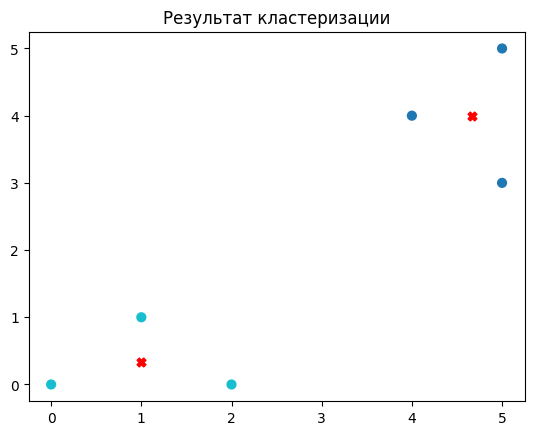

In [70]:
A = np.array([[1, 1], [0, 0], [2, 0], [4, 4], [5, 5], [5, 3]])

kmeans_model = KMeans2(clusters=2)
labels, centroids = kmeans_model.fit_predict(A)
print(centroids, labels)
draw_plot(A, centroids)

[[ 4.67841426  1.89528916]
 [-2.86194346  8.61218144]
 [-6.90554506 -6.84863565]
 [-2.10046154  9.7436542 ]] [2 1 2 0 3 1 3 2 1 0 2 1 2 1 2 0 0 1 0 2 3 2 1 1 1 2 2 3 0 2 2 0 2 2 1 0 3
 0 1 0 3 2 2 2 0 0 3 0 1 0 1 2 0 0 0 2 3 3 2 0 0 0 2 0 1 3 0 0 0 2 1 2 2 1
 2 3 2 0 3 3 0 3 2 2 0 0 2 0 3 2 0 1 2 0 1 2 2 0 0 3 0 3 1 2 2 0 0 0 0 1 1
 2 0 3 2 2 2 0 2 1 0 1 2 1 2 0 0 0 2 3 1 3 0 2 0 2 3 2 1 2 1 0 2 0 3 2 0 1
 2 3 2 3 2 1 2 3 0 3 1 1 1 1 0 2 3 2 0 2 2 2 2 1 0 0 0 1 3 3 0 2 0 1 0 0 2
 0 1 3 2 0 1 2 2 0 2 0 2 2 2 2 0 1 2 1 3 0 2 1 2 0 3 0 1 1 0 0 2 3 1 1 2 3
 3 0 0 1 0 1 0 1 0 1 0 2 2 0 2 2 0 0 1 3 2 1 0 0 1 1 0 0 0 0 1 2 0 2 1 0 2
 2 1 0 0 2 2 0 2 2 1 0 3 0 2 1 3 2 1 3 0 2 1 3 2 2 3 1 2 2 2 0 0 2 1 3 0 2
 3 1 1 2 2 0 2 0 0 2 0 2 2 1 3 1 2 0 1 3 0 1 0 0 0 0 2 2 1 0 2 1 0 3 1 0 1
 0 2 0 2 1 1 2 2 2 0 1 2 0 0 2 2 3 0 0 2 0 2 0 0 1 0 3 2 2 0 0 2 2 0 0 0 2
 1 2 2 2 1 2 0 2 0 0 3 0 0 2 2 1 1 0 0 2 1 2 1 3 2 0 0 2 1 3]


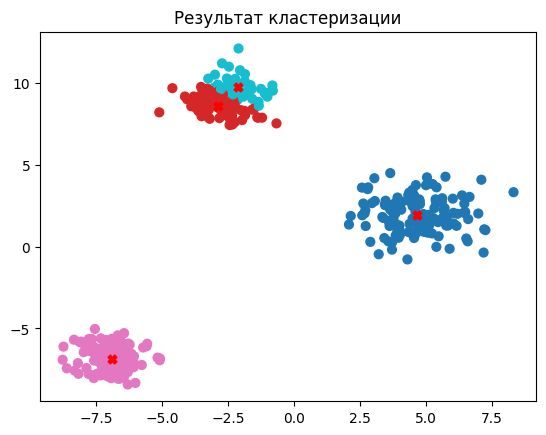

In [71]:
X, y_true = make_blobs(n_samples=400,
                       centers=3,
                       cluster_std=[0.8, 1.2, 0.7],
                       random_state=42)

kmeans_model = KMeans2(clusters=4)
labels, centroids = kmeans_model.fit_predict(X)
print(centroids, labels)
draw_plot(X, centroids)

#### Применение алгоритма кластеризации K-средних на датафреймах

[[0.44683908 0.58912916]
 [0.19601677 0.09497921]
 [0.71794872 0.79269883]] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 1 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 0 0]


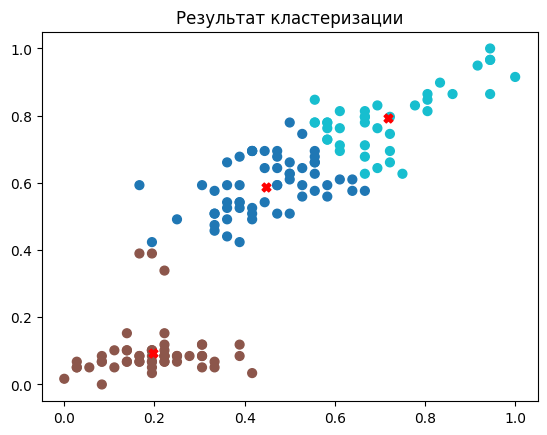

In [74]:
kmeans_model = KMeans2(clusters=3)
labels, centroids = kmeans_model.fit_predict(df, normalize=True)
print(centroids, labels)
df_norm = kmeans_model.normalize_data(df)
draw_plot(df_norm, centroids)

[[0.4168519  0.60575925]
 [0.08590164 0.75959184]
 [0.40969226 0.17436448]] [1 1 2 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0 0 2 0 2 0
 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0
 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0]


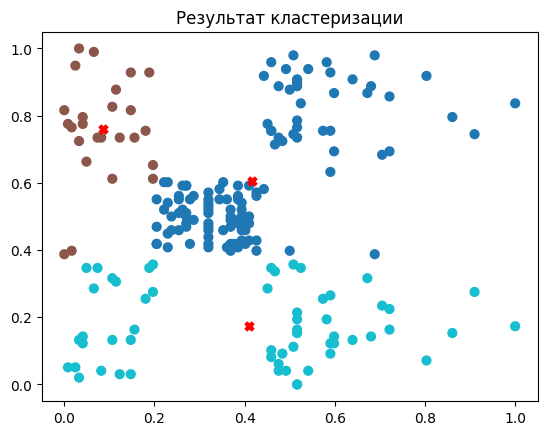

In [75]:
kmeans_model = KMeans2(clusters=3)
labels, centroids = kmeans_model.fit_predict(df2, normalize=True)
print(centroids, labels)
df2_norm = kmeans_model.normalize_data(df2)
draw_plot(df2_norm, centroids)